Imports:

In [10]:
# pip install albumentations

In [11]:
# Core Python
import os
import json

# Numerical + Image processing
import numpy as np
import cv2
import matplotlib.pyplot as plt

# COCO API for polygon → mask conversion
from pycocotools.coco import COCO
from pycocotools import mask as mask_util

# PyTorch data tools
import torch
from torch.utils.data import Dataset, DataLoader

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

Build Albumentations Transforms:

In [12]:
# Transformations for training
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, 
                       scale_limit=0.1, 
                       rotate_limit=0.1,
                       border_mode=cv2.BORDER_CONSTANT, p=0.5), 
    
    # Normalize image pixels to [-1,1] approximately
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    
    # Convert (H,W,C) → torch tensor (C,H,W)
    ToTensorV2()
])

# Validation and test transforms (No Augmentation)
val_transform = A.Compose([
    A.Normalize(mean=(0.5,0.5,0.5), 
                std=(0.5,0.5,0.5)),
    ToTensorV2()
])

Convert Polygon → Mask Function:

COCO polygon → RLE → binary mask

In [13]:
def polygons_to_mask(anns, height, width):
    """
    Convert a list of COCO polygon annotations for a single image
    into one binary mask of shape (height, width).
    """

    # Start with an empty mask
    mask = np.zeros((height, width), dtype=np.uint8)

    # Loop over annotations belonging to the same image
    for ann in anns:
        
        # ann["segmentation"] contains polygon(s)
        # Convert polygons → RLE
        rles = mask_util.frPyObjects(ann["segmentation"], height, width)
        
        # Merge them into a single RLE
        rle = mask_util.merge(rles)
        
        # Decode RLE → binary mask
        m = mask_util.decode(rle)
        
        # Combine: if any polygon says 1, the final mask gets 1
        mask = np.maximum(mask, m)

    return mask

The Dataset Class:

In [14]:
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        root_dir: folder containing images + _annotations.coco.json
        transform: Albumentations pipeline
        """
        self.root_dir = root_dir
        self.transform = transform

        # Path to annotation file
        ann_path = os.path.join(root_dir, "_annotations.coco.json")
        
        # Load COCO structure
        self.coco = COCO(ann_path)

        # List of image IDs
        self.image_ids = list(self.coco.imgs.keys())

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, index):
        """
        Returns:
          image_tensor: FloatTensor (3, H, W)
          mask_tensor:  FloatTensor (1, H, W)
        """
        img_id = self.image_ids[index]
        
        # --- Load image metadata ---
        img_info = self.coco.imgs[img_id]
        file_name = img_info["file_name"]
        height = img_info["height"]
        width = img_info["width"]

        # --- Load image ---
        img_path = os.path.join(self.root_dir, file_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # --- Load annotations for this image ---
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        # --- Convert polygons → mask ---
        mask = polygons_to_mask(anns, height, width)

        # Albumentations requires channel dimension for mask
        mask = mask.astype(np.uint8)
        
        # Add 1 channel dimension → shape (H,W,1)
        mask = np.expand_dims(mask, axis=2)

        # --- Apply transforms ---
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

        # Mask becomes (1, H, W) for PyTorch
        mask = mask.float()

        return image, mask

Test Dataset without Masks:

In [15]:
class BrainTumorTestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # All filenames (test has no JSON)
        self.filenames = [
            f for f in os.listdir(root_dir)
            if f.lower().endswith((".png", ".jpg", ".jpeg"))
        ]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        file_name = self.filenames[index]
        img_path = os.path.join(self.root_dir, file_name)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image=image)["image"]

        return image, file_name

Instantiate Datasets + DataLoaders:

In [16]:
train_dataset = BrainTumorDataset("../dataset/train", transform=train_transform)
val_dataset   = BrainTumorDataset("../dataset/valid", transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

len(train_dataset), len(val_dataset)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


(1502, 429)

Let's verify that dataset and transformers work:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


(np.float64(-0.5), np.float64(639.5), np.float64(639.5), np.float64(-0.5))

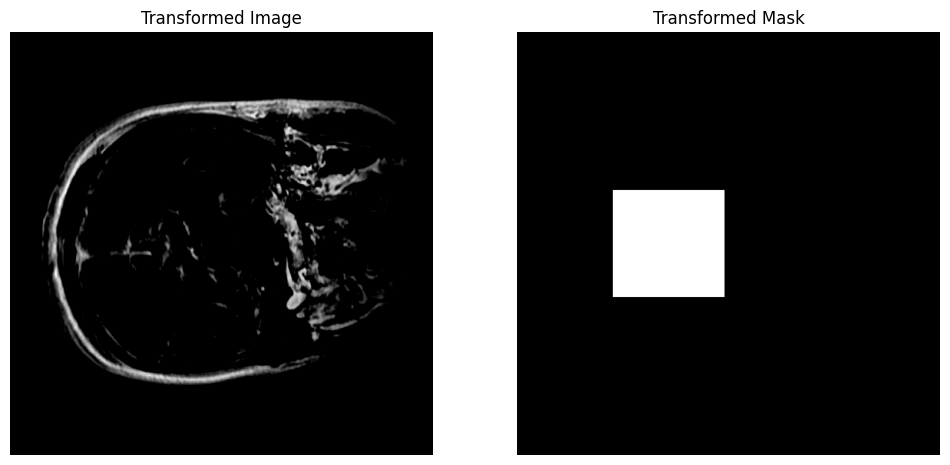

In [17]:
# Fetch one sample
image, mask = train_dataset[0]

# Convert back to NumPy for visualization
img_np = image.permute(1, 2, 0).numpy()
mask_np = mask.squeeze().numpy()

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.imshow(img_np)
plt.title("Transformed Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask_np, cmap="gray")
plt.title("Transformed Mask")
plt.axis("off")